In [1]:
import torch 
import time
iters = 10
vlen = iters * (iters*10) * (iters*100) 
ts = time.time()
for i in range(iters):
    rng = torch.rand(vlen).cuda()
    print(torch.exp(rng).cuda().mean())
te = time.time()
print("%f seconds %d" % (iters, te - ts))
print("val %s" % rng)

1.7182738780975342
1.718078851699829
1.7182437181472778
1.7193880081176758
1.7181984186172485
1.7188392877578735
1.7175267934799194
1.7186293601989746
1.7186734676361084
1.7179497480392456
10.000000 seconds 505
val 
 8.7814e-01
 1.9840e-01
 2.6958e-01
     ⋮     
 2.5200e-01
 8.3464e-01
 7.3883e-01
[torch.cuda.FloatTensor of size 1000000 (GPU 0)]



In [2]:
torch.__version__

'0.3.0'

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable


In [ ]:

import pyro
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam


In [3]:
rng=2
input1 = torch.rand(64*rng, 3*rng, 128*rng, 128*rng).cuda()
input2 = torch.rand(64*rng, 3*rng, 128*rng, 128*rng).cuda()
input1 = torch.autograd.Variable(input1, requires_grad=True)
input2 = torch.autograd.Variable(input2, requires_grad=True)
expected = torch.mul(input1, input2)
expected.mean()

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [15]:
import numpy as np
y=np.linspace(1,-1,3)
x=np.linspace(1,3,3)
xy=0
for i,j in zip(x,y):
    xy+=((i-x.mean())*(j-y.mean()))
    print(xy)
print(xy/(x.std()*y.std())/3)
np.correlate(x,y)
np.correlate((x-x.mean())/x.std(),(y-y.mean())/y.std())
np.corrcoef((x-x.mean())/x.std(),(y-y.mean())/y.std())
#np.corrcoef(x,y)

-1.0
-1.0
-2.0
-1.0


array([[ 1., -1.],
       [-1.,  1.]])

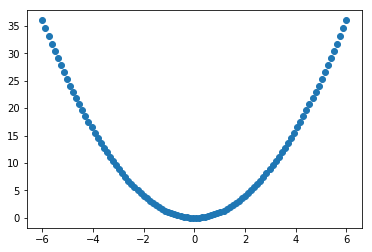

In [17]:
import matplotlib.pyplot as plt
N=100
x = np.linspace(-6, 6, num=N)
#x,y,z=build_linear_dataset(100)
y=x*x
plt.scatter(x,y)

In [18]:
N = 100  # size of toy data
p = 1    # number of features

def build_linear_dataset(N, noise_std=0.1):
    X = np.linspace(-6, 6, num=N)
    y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, y = X.reshape((N, 1)), y.reshape((N, 1))
    X, y = Variable(torch.Tensor(X)), Variable(torch.Tensor(y))
    return torch.cat((X, y), 1)

In [19]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)

    def forward(self, x):
        return self.linear(x)

regression_model = RegressionModel(p)

In [20]:
loss_fn = torch.nn.MSELoss(size_average=False)
optim = torch.optim.Adam(regression_model.parameters(), lr=0.01)
num_iterations = 500

def main():
    data = build_linear_dataset(N, p)
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.data[0]))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print("%s: %.3f" % (name, param.data.numpy()))

if __name__ == '__main__':
    main()

[iteration 0050] loss: 4405.9434
[iteration 0100] loss: 2648.9011
[iteration 0150] loss: 1519.3024
[iteration 0200] loss: 841.0806
[iteration 0250] loss: 464.6938
[iteration 0300] loss: 272.8968
[iteration 0350] loss: 183.5457
[iteration 0400] loss: 145.5780
[iteration 0450] loss: 130.8732
[iteration 0500] loss: 125.6824
Learned parameters:
linear.weight: 2.988
linear.bias: 1.073


In [21]:
#http://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#sphx-glr-beginner-blitz-data-parallel-tutorial-py
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
input_size = 5
output_size = 2
batch_size = 30
data_size = 100

In [22]:
class RandomDataset(Dataset):

    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(input_size, 100),
                         batch_size=batch_size, shuffle=True)

In [23]:
class Model(nn.Module):
    # Our model

    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.fc(input)
        print("  In Model: input size", input.size(),
              "output size", output.size())
        return output

In [24]:
model = Model(input_size, output_size)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

if torch.cuda.is_available():
   model.cuda()

Let's use 2 GPUs!


In [25]:
for data in rand_loader:
    if torch.cuda.is_available():
        input_var = Variable(data.cuda())
    else:
        input_var = Variable(data)

    output = model(input_var)
    print("Outside: input size", input_var.size(),
          "output_size", output.size())

  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
  In Model: input size torch.Size([15, 5]) output size torch.Size([15, 2])
Outside: input size torch.Size([30, 5]) output_size torch.Size([30, 2])
  In Model: input size torch.Size([5, 5]) output size torch.Size([5, 2])
  In Model: input size torch.Size([5, 5]) output size torch.Size([5, 2])
Outside: input size torch.Size([10, 5]) output_size torch.Size([10, 2])


In [ ]:
data = pd.read_csv("posw.csv")
data.head()

In [ ]:
%matplotlib inline
import numpy as np
#plt.hist(np.log2(data['expression']))
data.hist()

In [34]:
#https://www.youtube.com/watch?time_continue=96&v=vMZ7tK-RYYc
import numpy as np
import time

from numba import vectorize, cuda

#@vectorize(['float32(float32,float32)'],target='cuda')
def subVector(ε,σ):
    return ε + σ

Elements=10000000000
A=np.ones(Elements,dtype=np.float32)
B=np.ones(Elements,dtype=np.float32)
C=subVector(A,B)
ts=time.time()
te=time.time()
print(C,te-ts)

[2. 2. 2. ... 2. 2. 2.] 4.291534423828125e-05
